In [134]:
import scipy.stats as staty
import numpy.linalg as LA
import numpy as np
import pandas as pd
from random import sample
from matplotlib import pyplot as plt
temp_lj = pd.read_csv('Temp_LJ.csv')
temp_lj

,LETO,MESEC,TEMPERATURA
0,1986,1,0.1
1,1986,2,-2.8
2,1986,3,3.2
3,1986,4,10.2
4,1986,5,17.6
...,...,...,...
415,2020,8,22.2
416,2020,9,17.5
417,2020,10,11.9
418,2020,11,5.3


V datoteki Temp LJ se nahajajo izmerjene mesečne temperature v Ljubljani v 
letih od 1986 do 2020. Postavimo naslednja dva modela spreminjanja temperature
s časom: 

    - Model A: vključuje linearni trend in sinusno nihanje s periodo eno 
        leto.
    - Model B: vključuje linearni trend in spreminjanje temperature za 
        vsak mesec posebej.

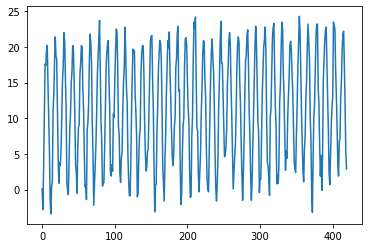

In [135]:
plt.plot(temp_lj['TEMPERATURA'])

(9.056666666666667, 13.273750000000005)

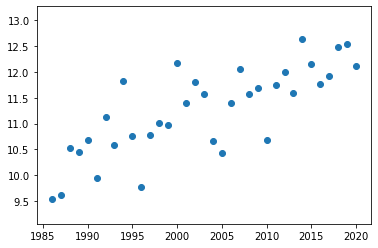

In [136]:
T = temp_lj['TEMPERATURA']
cas = temp_lj["LETO"]
leta = [cas[i] for i in range(420) if i % 12 == 0]
casPlot = np.array(leta)
T_leta = [np.average(T[k*12:(k+1)*12]) for k in range(35)]
Tplot = np.array(T_leta)
plt.scatter(casPlot, Tplot)
plt.ylim(min(Tplot)*0.95, 1.05*max(Tplot))

0.06463585434173644, -118.20894957983138


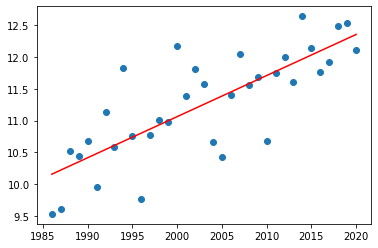

In [137]:
A = np.vstack([leta, np.ones(len(leta))]).T
result = LA.lstsq(A, T_leta, rcond=None)
k, n = result[0]
print(str(k) +', ' + str(n))
premica = [leta[i]*k + n for i in range(len(leta))]
plt.scatter(casPlot, Tplot)
plt.plot(casPlot, premica, 'r')

In [138]:
result

(array([ 6.46358543e-02, -1.18208950e+02]),
 array([9.34622106]),
 2,
 array([1.18500599e+04, 2.98296106e-02]))

a) Preizkusite model A znotraj modela B.

$$X_{ij} = a \cdot i + b + c \cdot \sin \Big(\frac{2\pi j}{12}\Big) + d \cdot \cos \Big(\frac{2\pi j}{12}\Big)$$

0.06463585434173237

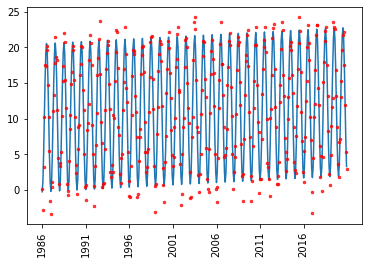

In [139]:
L = 420
leta = np.array([1986 + i//12 for i in range(420)])
leta = temp_lj["LETO"].values
enice = np.ones(L)
meseci = np.array([(1 + i%12) for i in range (420)])
sin_meseci = np.sin(meseci*np.pi/6)
cos_meseci = np.cos(meseci*np.pi/6)
M = np.array([leta,
             enice,
             sin_meseci,
             cos_meseci])
temperature = np.array(temp_lj['TEMPERATURA'])
result = LA.lstsq(M.T, temperature, rcond=None)

a, b, c, d = result[0]
model_A = [a*leta[l] + b + c*sin_meseci[l] + d*cos_meseci[l] for l in range(L)]
plt.plot(np.arange(420), model_A)
plt.plot(np.arange(420), temperature, 'ro', markersize=2.5, alpha=0.75)
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')
a

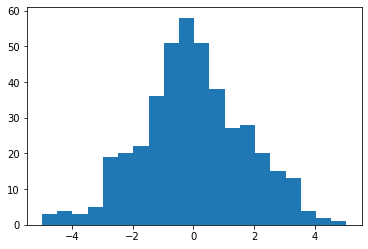

In [140]:
residual = temperature - model_A
z, xbins, _ = plt.hist(residual, bins=20)

([<matplotlib.axis.XTick at 0x1b41421aef0>,
 [Text(0, 0, '1986'),
  Text(60, 0, '1991'),
  Text(120, 0, '1996'),
  Text(180, 0, '2001'),
  Text(240, 0, '2006'),
  Text(300, 0, '2011'),
  Text(360, 0, '2016')])

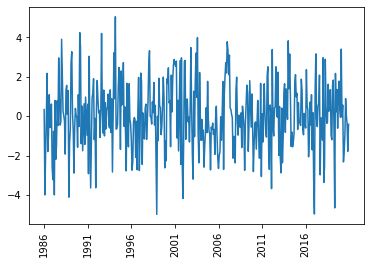

In [141]:
plt.plot(residual)
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')

In [142]:
a - 0.06463585434173644

-4.066191827689636e-15

Najprej bomo preverili linearni model

$$X_{ij} = a \cdot i + b$$

znotraj modela

$$X_{ij} = a \cdot i + b + c \cdot \sin \Big(\frac{2\pi j}{12}\Big) + d \cdot \cos \Big(\frac{2\pi j}{12}\Big)$$

torej preverili bomo s fischerjevim testom za p = 4, q = 2, n = 420.

Fischerjev test:

$$ F = \frac{\frac{RSS_W - RSS_V}{p-q}}{\frac{RSS_V}{n-p}} $$

kjer je $RSS$ vsota kvadratov rezidualov, W in V pa 2 in 4 dimenzionalna podprostora.

&H_0 : v \in W& in alternativna domneva $H_1 : v \notin W$. Če je 

$$F \geq F^{-1}_{Fischer(p-q, n-p)}(1-\alpha) $$

začetno domnevo $H_0$ zavrnemo, sicer pa sprejmemo.
Poračunajmo residuale:

In [164]:
p = 4
q = 2
alpha = 0.05
n = len(M[0])
resultV = LA.lstsq(M.T, temperature, rcond=None)
resultW = LA.lstsq(M[0:1].T, temperature, rcond=None)
RSS_V = float(resultV[1])
RSS_W = float(resultW[1])
F = (RSS_W - RSS_V)*(n-p)/((p-q)*RSS_V)
f = staty.f.isf(alpha, n-p, p-q)
F, f, F < f

(3772.9327478504333, 19.4933219988683, False)

Očitno model samo z linearnim trendom povsem ne ustreza glede na meritve. Poskusimo, da bo ožji model

$$X_{ij} = a \cdot i + b + c \cdot \sin \Big(\frac{2\pi j}{12}\Big) $$

se pravi da je $d=0$.

In [144]:
p = 4
q = 3
alpha = 0.05
n = len(M[0])
resultV = LA.lstsq(M.T, temperature, rcond=None)
resultW = LA.lstsq(M[0:2].T, temperature, rcond=None)
RSS_V = float(resultV[1])
RSS_W = float(resultW[1])
F = (RSS_W - RSS_V)*(n-p)/((p-q)*RSS_V)
f = staty.f.isf(alpha, n-p, p-q)
F, f, F < f

(7496.540617047239, 254.0077603850232, False)

Vzemimo zdaj za ožji model model A:

$$ X_{ij} = a \cdot i + b + c \cdot \sin \Big(\frac{2\pi j}{12}\Big) + d \cdot \cos \Big(\frac{2\pi j}{12}\Big) $$

pri modelu B pa dodamo neke random parametre

$$X_{ij} = a \cdot i + b + c \cdot \sin \Big(\frac{2\pi j}{12}\Big) + d \cdot \cos \Big(\frac{2\pi j}{12}\Big) + 
e \cdot j$$

In [145]:
sez = [i^2 for i in range(1, 421)]

M_1 = np.array([
             leta,
             enice,
             sin_meseci,
             cos_meseci,
             sez
])
result_1 = LA.lstsq(M_1.T, temperature, rcond=None)
p = 5
q = 4
alpha = 0.05
n = len(M[0])
resultV = LA.lstsq(M_1.T, temperature, rcond=None)
resultW = LA.lstsq(M.T, temperature, rcond=None)
RSS_V = resultV[1]
RSS_W = resultW[1]
F = (RSS_W - RSS_V)*(n-p)/((p-q)*RSS_V)
f = staty.f.isf(alpha, n-p, p-q)
F, f, F < f

(array([8.68936406]), 254.00702183226105, array([ True]))

-0.0852616202819263

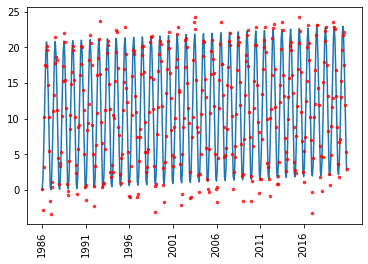

In [146]:
a, b, c, d, e = result_1[0]
model_A = [a*leta[l] + b + c*sin_meseci[l] + d*cos_meseci[l] + e*sez[l] for l in range(L)]
plt.plot(np.arange(420), model_A)
plt.plot(np.arange(420), temperature, 'ro', markersize=2.5, alpha=0.75)
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')
e

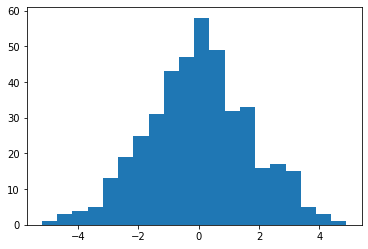

In [147]:
residual = temperature - model_A
z, xbins, _ = plt.hist(residual, bins=20)

([<matplotlib.axis.XTick at 0x1b414b092e8>,
 [Text(0, 0, '1986'),
  Text(60, 0, '1991'),
  Text(120, 0, '1996'),
  Text(180, 0, '2001'),
  Text(240, 0, '2006'),
  Text(300, 0, '2011'),
  Text(360, 0, '2016')])

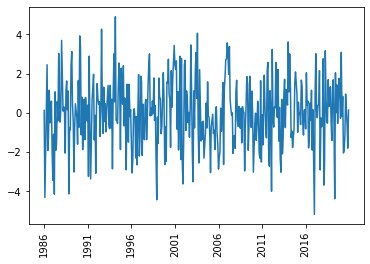

In [148]:
plt.plot(residual)
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')

([<matplotlib.axis.XTick at 0x1b414fe6b00>,
 [Text(0, 0, '1986'),
  Text(60, 0, '1991'),
  Text(120, 0, '1996'),
  Text(180, 0, '2001'),
  Text(240, 0, '2006'),
  Text(300, 0, '2011'),
  Text(360, 0, '2016')])

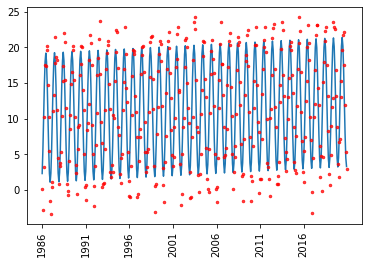

In [153]:
M_1 = np.array([
             leta,
             enice,
             cos_meseci
])
result_1 = LA.lstsq(M_1.T, temperature, rcond=None)
a, b, c = result_1[0]
model_A = [a*leta[l] + b + c*cos_meseci[l] for l in range(L)]
plt.plot(np.arange(420), model_A)
plt.plot(np.arange(420), temperature, 'ro', markersize=2.5, alpha=0.75)
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')

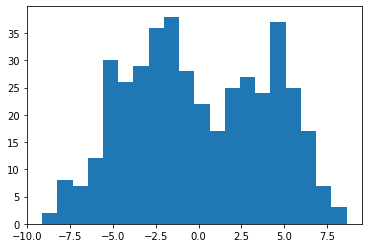

In [154]:
residual = temperature - model_A
z, xbins, _ = plt.hist(residual, bins=20)

([<matplotlib.axis.XTick at 0x1b4150fe6a0>,
 [Text(0, 0, '1986'),
  Text(60, 0, '1991'),
  Text(120, 0, '1996'),
  Text(180, 0, '2001'),
  Text(240, 0, '2006'),
  Text(300, 0, '2011'),
  Text(360, 0, '2016')])

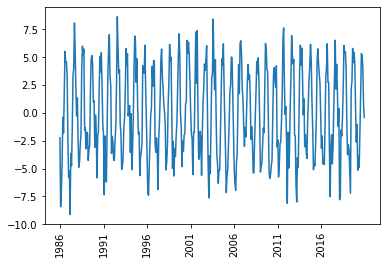

In [155]:
plt.plot(residual)
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')

In [160]:
M_1 = np.array([
             leta,
             enice,
             cos_meseci
])
result_1 = LA.lstsq(M_1.T, temperature, rcond=None)
p = 4
q = 3
alpha = 0.01
n = len(M[0])
resultV = LA.lstsq(M.T, temperature, rcond=None)
resultW = LA.lstsq(M_1.T, temperature, rcond=None)
RSS_V = resultV[1]
RSS_W = resultW[1]
F = (RSS_W - RSS_V)*(n-p)/((p-q)*RSS_V)
f = staty.f.isf(alpha, n-p, p-q)
F, f, F < f

(array([1820.86510202]), 6358.216507760212, array([ True]))

b) Pri modeliranju je nevarno privzeti preširok model: lahko bi recimo postavili
model, po katerem je temperatura vsak mesec drugačna, neidvisno od ostalih
mesecev, a tak model bi bil neuporaben za napovedovanje. Akaikejeva 
informacija nam pomaga poiskati optimalni model – izberemo tistega, za katerega
je le-ta najmanjša. Akaikejeva informacija je sicer definirana z verjetjem, 
a pri linearni regresiji in Gaussovem modelu je le-ta ekvivalentna naslednji 
modifikaciji:  
$$\text{AIC} := 2m + n \ln \text{RSS,}
$$
kjer je m število parametrov, n pa je število opažanj. Kateri od zgornjih dveh
modelov ima manjšo Akaikejevo informacijo?